In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units, constants

import sys
sys.path.append("../..")
from utils.plot_utils import set_fontsize
from scipy.stats import norm

## Velocity Broadening
The beamsource can be modelled as an extended source, spawning molecules in a 2D gaussian distribution with width $\sigma = 4.83 mm$ at 1 cm from the cell opening.  
From Oskari's beamsource characterization report the forward velocity is 184 m/s $\pm$ 16.8 m/s, width a transverse velocity $\sigma_\perp = 93/2\sqrt{2}\log{2}$ m/s.  

The Doppler shift in frequency is given by $f = f_0 \left(1+v/c\right)$, where $f_0$ is the rest frequency.

In [2]:
@units.quantity_input
def doppler_shift(v: units.m/units.s, frequency: units.Hz):
    return (frequency*(1+v/constants.c)).to(units.Hz)

In [3]:
Γ = (1/(100*units.ns)).to(units.Hz)
vp = 1*units.m/units.s
ω = (2*np.pi*constants.c/(271*units.nm)).to(units.Hz)

In [4]:
v_to_Γ = (doppler_shift(vp,ω) - ω)/Γ
print(f'1 m/s transverse velocity results in a frequency shift of {v_to_Γ:.2f} Γ')

1 m/s transverse velocity results in a frequency shift of 2.32 Γ


The rotational cooling detection scheme has 2 apertures with a radius of 4 mm, one placed before the rotational cooling chamber and another before the detection chamber.

Now spawning the molecules with random positions and velocities, drawn from gaussian distributions.

In [5]:
# from Oskari's Beam Characterization report
vcm = 184
vcm_sigma = 16.8
vt_sigma = 93/(2*np.sqrt(2*np.log(2))) # from FWHM

# coordinate width, adapted from ACME to CeNTREX based on email from Xing Wu on 6-10-2020
sigma_width = 0.25*25.4/5 * 3.8e-3

v_acceptable = 1.5 # m/s

v_laser = 1.5 # m/s, molecules the laser can interact with
r_laser = 5e-3 # m

In [6]:
generate_random_r = lambda x: np.random.normal(0,sigma_width,x)
generate_random_longitudinal_velocities = lambda x: np.random.normal(vcm, vcm_sigma, x)

def generate_random_coords(size):
    xy = np.empty([2,size])
    xy[0,:] = generate_random_r(size)
    xy[1,:] = generate_random_r(size)
    return xy
            
def generate_random_transverse_velocities(size):
    v_transverse = np.random.multivariate_normal([0,0],np.array([[vt_sigma**2,0],[0,vt_sigma**2]]),size).T
    return v_transverse

In [7]:
np.random.seed(42)
size = int(1e7)
coords = generate_random_coords(size)
v_z = generate_random_longitudinal_velocities(size)
v_x, v_y = generate_random_transverse_velocities(size)

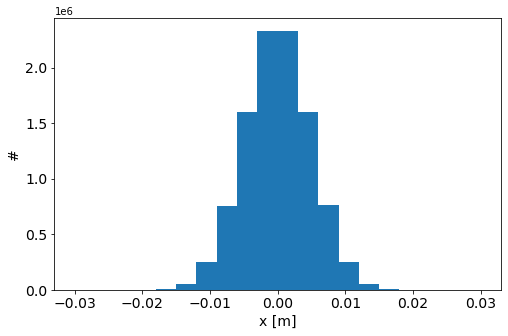

In [8]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(coords[0,:], bins = np.linspace(-0.03, 0.03, 21))
ax.set_xlabel('x [m]')
ax.set_ylabel('#')

set_fontsize(ax, 14)

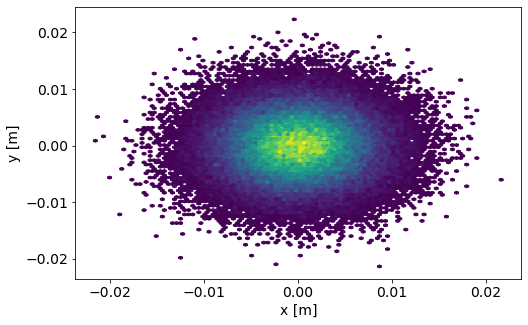

In [9]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(coords[0,:][:int(1e5)],coords[1,:][:int(1e5)], mincnt = 1)
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

set_fontsize(ax, 14)

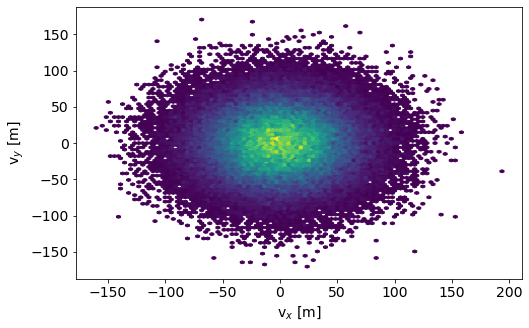

In [10]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hexbin(v_x[:int(1e5)], v_y[:int(1e5)], mincnt = 1)
ax.set_xlabel(r'v$_x$ [m]')
ax.set_ylabel(r'v$_y$ [m]')

set_fontsize(ax, 14)

### Without Aperture
Without an aperture there are several transverse velocity limiting components in the beamline.  
The closest to the rotational cooling chamber is the entrance flange, where the 1st colimator would also be placed.
The distance from the assumed extended source of this component is 17.36" - 1 cm, and the opening diameter is 60 mm.

In [11]:
in_to_m = (units.imperial.inch).to(units.m)

In [12]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

filtered = np.empty([3,size])

dt = distance_aperture_1/v_z
filtered[0,:] = coords[0,:]+dt*v_x
filtered[1,:] = coords[1,:]+dt*v_y
filtered[2,:] = distance_aperture_1

m = np.sqrt(np.sum(filtered[:2,:]**2, axis = 0)) < 60/2 * 1e-3
size = m.sum()

v_x_full, v_y_full, v_z_full = v_x.copy(), v_y.copy(), v_z.copy()
v_x, v_y, v_z = v_x[m], v_y[m], v_z[m]

coords_full = coords.copy()
coords = np.empty([2,size])
coords[0,:] = coords_full[0,:][m]
coords[1,:] = coords_full[1,:][m]

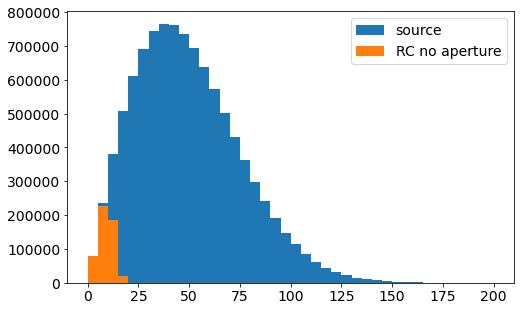

In [13]:
dx = 5
b = np.arange(0,200+dx,dx)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(np.sqrt(v_x_full**2+v_y_full**2), bins = b, label = 'source')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = b, label = 'RC no aperture')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

distance to RC laser from cell opening is 21.75"  
distance to aperture #1 from cell opening is 17.36"  

distance to LIF laser from cell opening is 38.39"  
distance to aperture #2 from cel opening is 35.37" 

In [14]:
distance_aperture_1 = 17.36 * in_to_m - 0.01

coords_aperture_1 = np.empty([3,size])

dt = distance_aperture_1/v_z
coords_aperture_1[0,:] = coords[0,:]+dt*v_x
coords_aperture_1[1,:] = coords[1,:]+dt*v_y
coords_aperture_1[2,:] = distance_aperture_1

In [15]:
distance_aperture_2 = 31 * in_to_m - 0.01

coords_aperture_2 = np.empty([3,size])

dt = distance_aperture_2/v_z
coords_aperture_2[0,:] = coords[0,:]+dt*v_x
coords_aperture_2[1,:] = coords[1,:]+dt*v_y
coords_aperture_2[2,:] = distance_aperture_2

In [16]:
distance_laser_rc = 21.75 * in_to_m - 0.01
dt = distance_laser_rc/v_z

m_interaction_rc = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_rc = np.sum(m_interaction_rc)

In [17]:
distance_laser_lif = 38.30 * in_to_m - 0.01
dt = distance_laser_lif/v_z

m_iteraction_lif = (np.abs(coords[1,:]+dt*v_y) <= r_laser) & (np.abs(v_x) <= v_laser)
interaction_lif = np.sum(m_iteraction_lif)

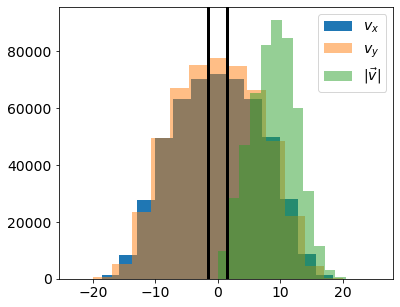

In [18]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$')
ax.hist(v_y, bins = bins, alpha = 0.5, label = r'$v_y$')
ax.hist(np.sqrt(v_x**2+v_y**2), bins = bins, alpha = 0.5, label = r'$|\vec{v}|$')

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

This figure shows the transverse velocity spread in the rotational cooling chamber.

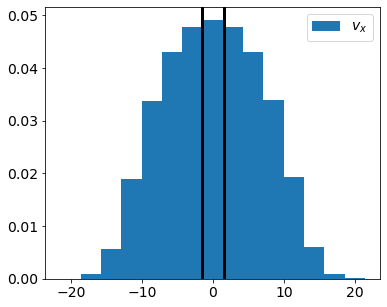

In [19]:
fig, ax = plt.subplots(figsize = (6,5))

bins = 15

ax.hist(v_x, bins = bins, label = r'$v_x$', density=True)

ax.legend(fontsize = 14)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')
set_fontsize(ax, 14)

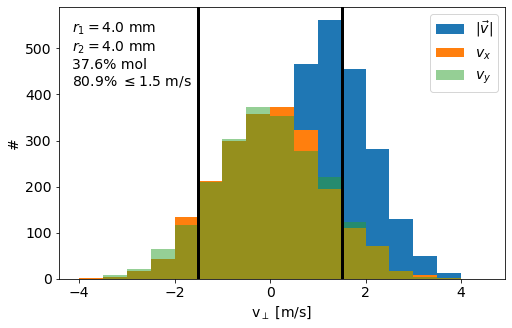

In [20]:
# calculating the velocity spread after 2 apertures
# both with an aperture radius of 4 mm

r1 = 4e-3
r2 = 4e-3

bins = np.arange(-4,4+1,0.5)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

ax.hist(np.sqrt(v_x[m]**2+v_y[m]**2), bins = bins, label = r'$|\vec{v}|$')
ax.hist(v_x[m], bins = bins, label = r'$v_x$')
ax.hist(v_y[m], bins = bins, alpha = 0.5, label = r'$v_y$')

ax.legend(fontsize = 14, loc = 1)

ax.axvline(v_acceptable, lw = 3, color = 'k')
ax.axvline(-v_acceptable, lw = 3, color = 'k')

ax.set_xlabel(r'v$_\perp$ [m/s]')
ax.set_ylabel('#')

set_fontsize(ax, 14)
    
dt = distance_laser_lif/v_z[m]
m_interact = (np.abs(coords[1,:][m]+dt*v_y[m]) <= r_laser) & (np.abs(v_x[m]) <= v_laser)
interact = m_interact.sum()/interaction_lif*100

text = f'$r_1 = ${r1*1e3:.1f} mm'+'\n'
text += f'$r_2 = ${r2*1e3:.1f} mm'+'\n'
text += f'{m.sum()/interaction_lif*100:.1f}% mol'+'\n'
text += f'{(100*(np.abs(v_x[m]) < 1.5).sum()/m.sum()):.1f}% $\leq {v_acceptable}$ m/s'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

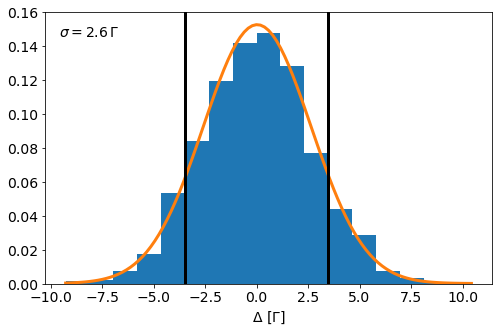

In [21]:
bins = np.arange(-4*v_to_Γ,(4+1)*v_to_Γ,0.5*v_to_Γ)

fig, ax = plt.subplots(figsize = (8,5))

m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

mask_filtered_beam = m.copy()

ax.hist(v_x[m]*v_to_Γ, bins = bins, label = r'$v_x$', density = True)

mu, sigma = norm.fit(v_x[m]*v_to_Γ)

_x = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_x, norm.pdf(_x, mu, sigma), lw = 3)

ax.axvline(v_acceptable*v_to_Γ, lw = 3, color = 'k')
ax.axvline(-v_acceptable*v_to_Γ, lw = 3, color = 'k')

ax.set_xlabel(r'$\Delta$ [Γ]')
set_fontsize(ax, 14)

text = f'$\sigma = ${sigma:.1f}$\,$Γ'
ax.text(0.03, 0.95, text, transform = ax.transAxes,
        ha = 'left', va = 'top', fontsize = 14);

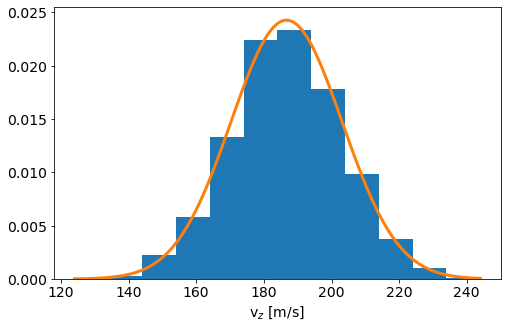

In [22]:
bins = np.linspace(184-60, 184+60, 13)

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(v_z[m], density = True, bins = bins)


mu_z, sigma_z = norm.fit(v_z[m])

_z = np.linspace(bins.min(), bins.max(), 101)
ax.plot(_z, norm.pdf(_z, mu_z, sigma_z), lw = 3)


ax.set_xlabel(r'v$_z$ [m/s]')
set_fontsize(ax, 14)

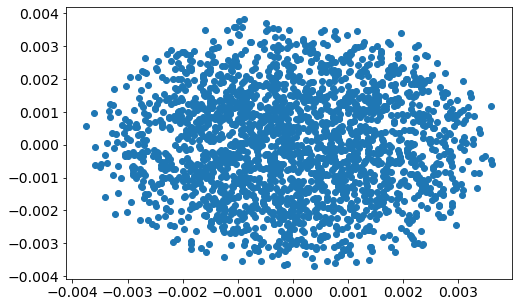

In [23]:
m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

t_rc = distance_laser_rc/v_z[m]

fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(v_x[m]*t_rc + coords[0,m], v_y[m]*t_rc + coords[1,m])
set_fontsize(ax, 14)

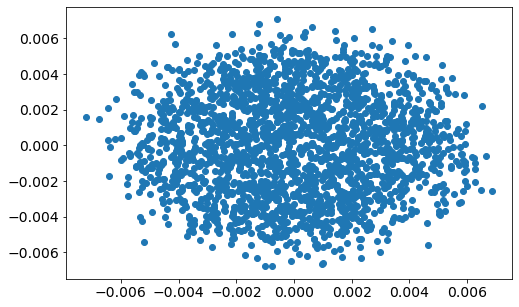

In [24]:
m1 = np.sqrt(np.sum(coords_aperture_1[:2]**2, axis = 0)) <= r1
m2 = np.sqrt(np.sum(coords_aperture_2[:2]**2, axis = 0)) <= r2
m  = m1 & m2

t_lif = distance_laser_lif/v_z[m]

fig, ax = plt.subplots(figsize = (8,5))

ax.scatter(v_x[m]*t_lif + coords[0,m], v_y[m]*t_lif + coords[1,m])

set_fontsize(ax, 14)

In [25]:
_ = np.vstack([coords[0,m], coords[1,m], np.zeros(m.sum()), v_x[m], v_y[m], v_z[m]])
np.save("trajectories", _)